In [13]:
import pandas as pd
import numpy as np

# 머신러닝 도구
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 불균형 데이터를 위한 라이브러리
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier

# 평가 지표
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

# 경고 무시
from warnings import filterwarnings
filterwarnings('ignore')

In [14]:
file_path = './data/'
file_name = 'netflix_feature_engineered.csv'

# 사전 작업: 데이터 로드 및 분리

In [15]:
# --- 데이터 로드 및 분리
df = pd.read_csv(file_path + file_name)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# LightGBM

In [61]:
# --- 모델 파이프라인 구축
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

model = LGBMClassifier(random_state=42, class_weight='balanced')

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])

# --- 모델 학습
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 70573, number of negative: 70573
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35569
[LightGBM] [Info] Number of data points in the train set: 141146, number of used features: 2258
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [62]:
# --- 모델 예측 및 평가
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.75      0.33      3592
           1       0.96      0.66      0.78     30246

    accuracy                           0.67     33838
   macro avg       0.58      0.71      0.56     33838
weighted avg       0.88      0.67      0.74     33838



## SMOTE 대신 가중치 부여

In [37]:
# --- 가중치 조정
# 가중치 배열 생성 -> 기본 가중치 = 1
sample_weights = np.ones(len(y_train))

# 가중치 부여 조건 설정(EDA 결과 기반)
# 조건 1: 고객 중 20~50대인 경우 가중치 5 부여
condition2 = (y_train == 0) & (X_train['Age_group'].isin(['50', '60', '70']))
sample_weights[condition2] = 5

# 조건 2. 이탈 고객 중 구독 기간이 6개월 이하인 경우 가중치 5 부여
condition1 = (y_train == 0) & (X_train['Subscription Length (Months)'] > 6)
sample_weights[condition1] = 5

In [38]:
# --- 모델 파이프라인 구축
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

model = LGBMClassifier(random_state=42, class_weight='balanced', sample_weight=sample_weights)

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# --- 모델 학습
pipeline.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Info] Number of positive: 70573, number of negative: 8382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 78955, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [66]:
# 평가
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.75      0.33      3592
           1       0.96      0.66      0.78     30246

    accuracy                           0.67     33838
   macro avg       0.58      0.71      0.56     33838
weighted avg       0.88      0.67      0.74     33838



# SMOTE와 가중치 모두 부여
- 소수 클래스에 가중치를 크게

In [46]:
condition1 = (y_train == 0)
sample_weights[condition1] = 100

In [47]:
# --- 모델 파이프라인 구축
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

model = LGBMClassifier(random_state=42, class_weight='balanced', sample_weight=sample_weights)

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# --- 모델 학습
pipeline.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Warning] Unknown parameter: sample_weight
[LightGBM] [Info] Number of positive: 70573, number of negative: 8382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 78955, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# 평가
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: sample_weight
              precision    recall  f1-score   support

           0       0.20      0.77      0.32      3592
           1       0.96      0.64      0.77     30246

    accuracy                           0.66     33838
   macro avg       0.58      0.71      0.55     33838
weighted avg       0.88      0.66      0.72     33838



---
# 최적 임계값 찾아보기
- 정밀도와 재현율이 같아지는 지점
- 두 클래스에 대한 정밀도가 같아지는 지점
- 두 클래스에 대한 재현율이 같아지는 지점

In [81]:
# --- 정밀도와 재현율이 같아지는 임계값 찾기
def predict_equal_precall(model, X_test, y_test):
    # predict_proba -> (Class 0, Class 1)
    pred_proba = model.predict_proba(X_test)[:, 1]

    # 최적의 임계값 찾기 -> 정밀도와 재현율이 교차하는 지점의 인덱스
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)

    precisions = precisions[:-1]
    recalls = recalls[:-1]

    # 정밀도 또는 재현율이 0 또는 1인 경우를 제외하기 위한 마스크
    mask = (precisions > 0) & (precisions < 1) & (recalls > 0) & (recalls < 1)

    # 마스크를 적용하여 유효한 값만 필터링
    filtered_precisions = precisions[mask]
    filtered_recalls = recalls[mask]
    filtered_thresholds = thresholds[mask]

    idx = np.argmin(np.abs(filtered_precisions - filtered_recalls))
    best_threshold = filtered_thresholds[idx]

    y_pred = (pred_proba >= best_threshold).astype(int)

    return best_threshold, y_pred

# --- 두 클래스에 대한 재현율이 같아지는 임계값 찾기
def predict_equal_recall(model, X_test, y_test):
    pred_proba = model.predict_proba(X_test)[:, 1]

    # 클래스 1을 기준으로 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    recalls_tpr = recalls[:-1]
    
    # 각 임계값에 대한 Recall을 저장할 리스트
    tnr_scores = []
    
    for th in thresholds:
        y_pred_temp = (pred_proba >= th).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
        
        tnr = tn / (tn + fp)
        tnr_scores.append(tnr)

    diffs = np.abs(recalls[:-1] - tnr_scores)
    best_idx = np.argmin(diffs)
    
    best_threshold = thresholds[best_idx]
    
    y_pred = (pred_proba >= best_threshold).astype(int)

    return best_threshold, y_pred

# --- 두 클래스에 대한 정밀도가 같아지는 임계값 찾기
def predict_equal_precision(model, X_test, y_test):
    pred_proba = model.predict_proba(X_test)[:, 1]

    # 클래스 1을 기준으로 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)

    # 각 임계값에 대한 Precision을 저장할 리스트
    pre_scores = []
    
    for th in thresholds:
        y_pred_temp = (pred_proba >= th).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
        
        pre = tn / (tn + fn) if (tn + fn) > 0 else 0
        pre_scores.append(pre)

    diffs = np.abs(precisions[:-1] - pre_scores)
    best_idx = np.argmin(diffs)
    
    best_threshold = thresholds[best_idx]
    
    y_pred = (pred_proba >= best_threshold).astype(int)

    return best_threshold, y_pred

In [50]:
# --- 모델 파이프라인 구축
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

model = LGBMClassifier(random_state=42, class_weight='balanced')

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])

# --- 모델 학습
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 70573, number of negative: 70573
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35569
[LightGBM] [Info] Number of data points in the train set: 141146, number of used features: 2258
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [80]:
best_threshold, y_pred_precall = predict_equal_precall(pipeline, X_test, y_test)
print("== 정밀도와 재현율이 같아지는 지점 ==")
print(f"최적 임계값: {best_threshold:.2f}")
print(classification_report(y_test, y_pred_precall))

best_threshold, y_pred_precision = predict_equal_precision(pipeline, X_test, y_test)
print("== 두 클래스에 대한 정밀도가 같아지는 지점 ==")
print(f"최적 임계값: {best_threshold:.2f}")
print(classification_report(y_test, y_pred_precision))

best_threshold, y_pred_recall = predict_equal_recall(pipeline, X_test, y_test)
print("== 두 클래스에 대한 재현율이 같아지는 지점 ==")
print(f"최적 임계값: {best_threshold:.2f}")
print(classification_report(y_test, y_pred_recall))

== 정밀도와 재현율이 같아지는 지점 ==
최적 임계값: 0.29
              precision    recall  f1-score   support

           0       0.30      0.30      0.30      3592
           1       0.92      0.92      0.92     30246

    accuracy                           0.85     33838
   macro avg       0.61      0.61      0.61     33838
weighted avg       0.85      0.85      0.85     33838

== 두 클래스에 대한 정밀도가 같아지는 지점 ==
최적 임계값: 0.99
              precision    recall  f1-score   support

           0       0.11      1.00      0.19      3592
           1       0.00      0.00      0.00     30246

    accuracy                           0.11     33838
   macro avg       0.05      0.50      0.10     33838
weighted avg       0.01      0.11      0.02     33838

== 두 클래스에 대한 재현율이 같아지는 지점 ==
최적 임계값: 0.47
              precision    recall  f1-score   support

           0       0.22      0.70      0.33      3592
           1       0.95      0.70      0.81     30246

    accuracy                           0.70     33838
   macr

---
## 성능 지표 테이블

In [82]:
# 성능 지표 테이블
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from lightgbm import LGBMClassifier

df = pd.read_csv('./data/netflix_feature_engineered.csv')
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

model = LGBMClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_processed, y_train)

pred_proba = model.predict_proba(X_test_processed)[:, 1]

results = []
thresholds = np.linspace(0.05, 0.95, 20)

precision_curve, recall_curve, _ = precision_recall_curve(y_test, pred_proba)
pr_auc = auc(recall_curve, precision_curve)

for thresh in thresholds:
    y_pred = (pred_proba >= thresh).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results.append({
        'Threshold': thresh,
        'Balanced_Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Macro_F1': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, pred_proba), # ROC-AUC는 확률값으로 계산
        'PR_AUC': pr_auc,
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
    })

df_results = pd.DataFrame(results[1:])

[LightGBM] [Info] Number of positive: 70573, number of negative: 8382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 78955, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [83]:
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc
)

pred_proba = pipeline.predict_proba(X_test)[:, 1]

results = []
thresholds = np.linspace(0.05, 0.95, 20)

precision_curve, recall_curve, _ = precision_recall_curve(y_test, pred_proba)
pr_auc = auc(recall_curve, precision_curve)

for thresh in thresholds:
    y_pred = (pred_proba >= thresh).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results.append({
        'Threshold': thresh,
        'Balanced_Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Macro_F1': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, pred_proba), # ROC-AUC는 확률값으로 계산
        'PR_AUC': pr_auc,
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
    })

df_results = pd.DataFrame(results[1:])

In [72]:
df_results[['Threshold', 'Macro_F1', 'ROC_AUC', 'PR_AUC', 'Precision_0', 'Recall_0', 'Precision_1', 'Recall_1']].round(4)

,Threshold,Macro_F1,ROC_AUC,PR_AUC,Precision_0,Recall_0,Precision_1,Recall_1
0,0.0974,0.4720,0.7719,0.9645,0.0000,0.0000,0.8938,1.0000
1,0.1447,0.4720,0.7719,0.9645,0.0000,0.0000,0.8938,1.0000
2,0.1921,0.5079,0.7719,0.9645,0.4138,0.0401,0.8970,0.9933
3,0.2395,0.5696,0.7719,0.9645,0.3521,0.1431,0.9049,0.9687
4,0.2868,0.6087,0.7719,0.9645,0.2986,0.3037,0.9171,0.9153
5,0.3342,0.6141,0.7719,0.9645,0.2707,0.4443,0.9286,0.8579
6,0.3816,0.6004,0.7719,0.9645,0.2445,0.5663,0.9389,0.7922
7,0.4289,0.5847,0.7719,0.9645,0.2290,0.6523,0.9471,0.7392
8,0.4763,0.5671,0.7719,0.9645,0.2162,0.7135,0.9532,0.6928
9,0.5237,0.5492,0.7719,0.9645,0.2066,0.7781,0.9608,0.6452


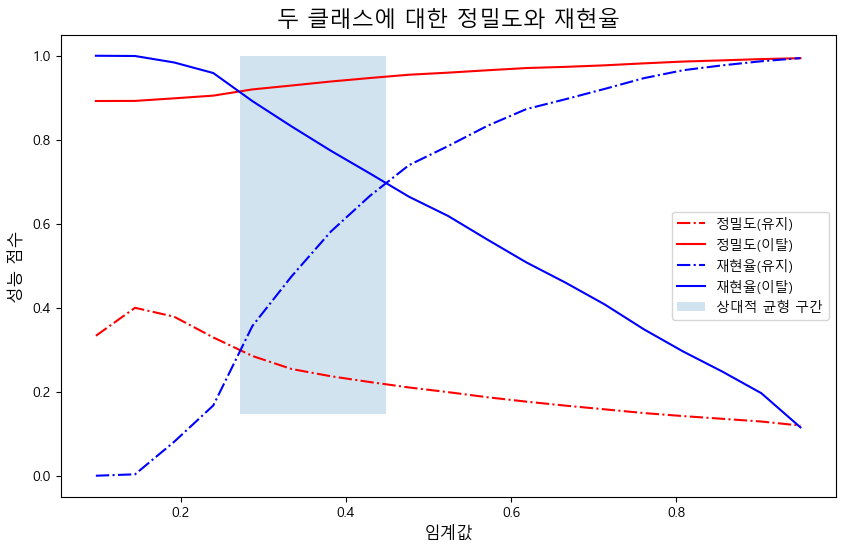

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

x = df_results['Threshold']

plt.figure(figsize=(10, 6))
plt.plot(x, df_results['Precision_0'], 'r-.', label='정밀도(유지)')
plt.plot(x, df_results['Precision_1'], 'r', label='정밀도(이탈)')
plt.plot(x, df_results['Recall_0'], 'b-.', label='재현율(유지)')
plt.plot(x, df_results['Recall_1'], 'b', label='재현율(이탈)')

# 최적 구간 찾아서 시각화
start = df_results['Threshold'][4] - 0.015
end = df_results['Threshold'][9] - 0.075
plt.fill_betweenx(y=df_results['Threshold']+0.05, x1=start, x2=end, alpha=0.2, label='상대적 균형 구간')
# plt.axvspan(start, end, color='gray', alpha=0.2, label='상대적 균형 구간')

plt.title('두 클래스에 대한 정밀도와 재현율', fontsize=16)
plt.xlabel('임계값', fontsize=12)
plt.ylabel('성능 점수', fontsize=12)

plt.legend()
plt.show()

## 정밀도 vs 재현율 시각화

In [64]:
# 정밀도 vs 재현율 시각화 모듈
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 6))

    plt.plot(thresholds, precisions[:-1], "b", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best F1 Threshold: {best_threshold:.2f}')
    
    plt.title('Precision-Recall vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')

    plt.grid()
    plt.legend()

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.show()

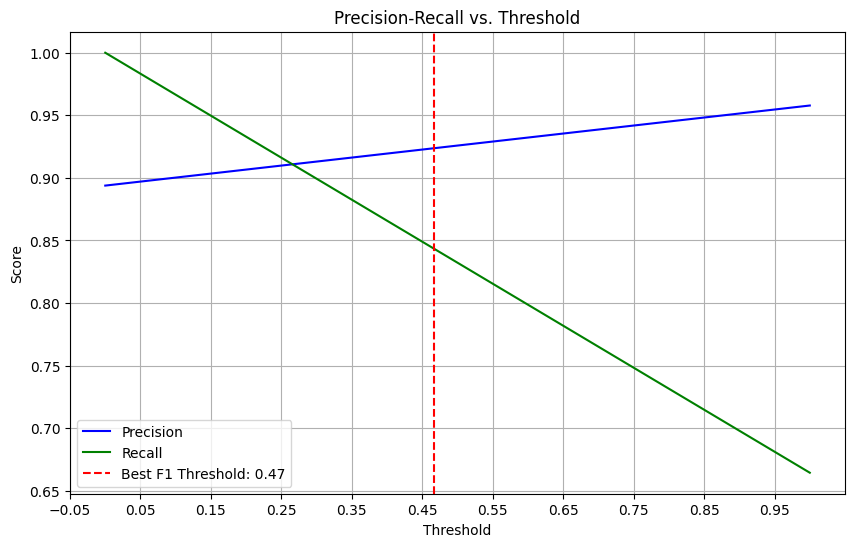

In [67]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

---
## 딥러닝 시도
- 정형 데이터에 대한 딥러닝의 경우 은닉층이 깊어지면 과적합 위험이 높으므로 레이어를 적게

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# --- [추가된 부분 1] Keras 콜백 임포트 ---
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [87]:
# 1. 데이터 로드 및 전처리 (이전과 동일)
df = pd.read_csv('./data/netflix_feature_engineered.csv')

df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(len(weights))}

# 딥러닝 모델 구축 및 컴파일
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# 조기 종료 -> 검증 손실(val_loss)이 5번 연속으로 개선되지 않으면 학습을 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# 최적 모델 저장 -> 검증 손실이 가장 낮은 최고의 모델 가중치를 'best_model.h5' 파일로 저장
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# 학습률 감소 -> 검증 손실이 3번 연속으로 개선되지 않으면 학습률을 50% 감소
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


# 모델 학습 시 콜백 적용
history = model.fit(
    X_train_processed,
    y_train,
    epochs=5, # 최대 epoch를 늘려주고, 조기 종료에 맡김
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/5
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6519 - loss: 0.6133 - precision_2: 0.9482 - recall_2: 0.6457
Epoch 1: val_loss improved from None to 0.56535, saving model to best_model.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6325 - loss: 0.5908 - precision_2: 0.9564 - recall_2: 0.6170 - val_accuracy: 0.6349 - val_loss: 0.5653 - val_precision_2: 0.9589 - val_recall_2: 0.6179 - learning_rate: 0.0010
Epoch 2/5
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6599 - loss: 0.5579 - precision_2: 0.9642 - recall_2: 0.6425
Epoch 2: val_loss improved from 0.56535 to 0.55393, saving model to best_model.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6617 - loss: 0.5512 - precision_2: 0.9653 - recall_2: 0.6447 - val_accuracy: 0.6531 - val_loss: 0.5539 - val_precision_2: 0.9541 - val_recall_2: 0.6427 - learning_rate: 0.0010
Epoch 3/5
986/987 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7541 - loss: 0.4560 - precision_2: 0.9759 - recall_2: 0.7430
Epoch 3: val_loss improved from 0.55393 to 0.50425, saving model to best_model.h5


987/987 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.8020 - loss: 0.4085 - precision_2: 0.9794 - recall_2: 0.7952 - val_accuracy: 0.7095 - val_loss: 0.5042 - val_precision_2: 0.9388 - val_recall_2: 0.7220 - learning_rate: 0.0010
Epoch 4/5
987/987 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9783 - loss: 0.1261 - precision_2: 0.9960 - recall_2: 0.9797
Epoch 4: val_loss did not improve from 0.50425
987/987 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9808 - loss: 0.1033 - precision_2: 0.9966 - recall_2: 0.9818 - val_accuracy: 0.7249 - val_loss: 0.5390 - val_precision_2: 0.9251 - val_recall_2: 0.7532 - learning_rate: 0.0010
Epoch 5/5
985/987 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9949 - loss: 0.0324 - precision_2: 0.9991 - recall_2: 0.9952
Epoch 5: val_loss did not improve from 0.50425
987/987 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9942 - loss: 0.0318 - precision_2: 0.9991 - recall_2: 0.9945 - val_accuracy: 0.5271 - val_loss: 1.1095 - val_precision_2: 0.9563 

In [88]:
model.load_weights('best_model.h5') # 가장 성능이 좋았던 시점의 가중치

y_pred_proba = model.predict(X_test_processed)
y_pred = (y_pred_proba > 0.34).astype(int)

print(classification_report(y_test, y_pred))

1058/1058 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.23      0.33      0.27      3592
           1       0.92      0.87      0.89     30246

    accuracy                           0.81     33838
   macro avg       0.57      0.60      0.58     33838
weighted avg       0.84      0.81      0.83     33838

